<a href="https://colab.research.google.com/github/mpedraza98/MLTSA22_MPedraza/blob/main/HW6/MP_HW6_Point_of_Change_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

     |████████████████████████████████| 991 kB 7.0 MB/s 
Populating the interactive namespace from numpy and matplotlib


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

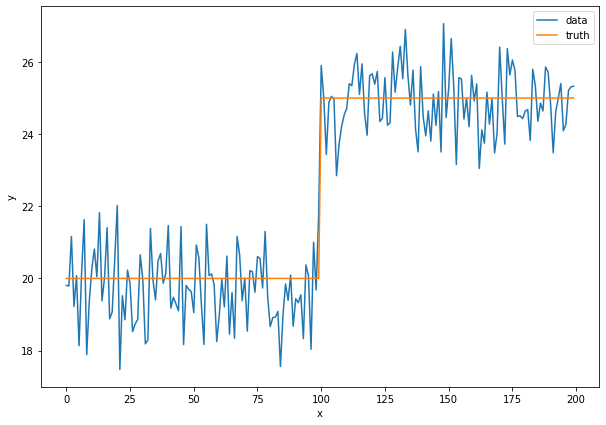

In [ ]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
fig = pl.figure(figsize=(10,7))
pl.plot(x, ym, label="data") 
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

**Fig 1** Synthetic dataset timeseries. There is only one point of discontinuity (POC) located at x = 100. Each point follows from a Stationary Gaussian process as $ y =c + \epsilon$ with $\epsilon \sim N(0,1).$ Before the POC the mean is 20 and after the mean is 25.

#<font color='red'> FBB ok</font>

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [ ]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
    
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.72, mean after: 24.93


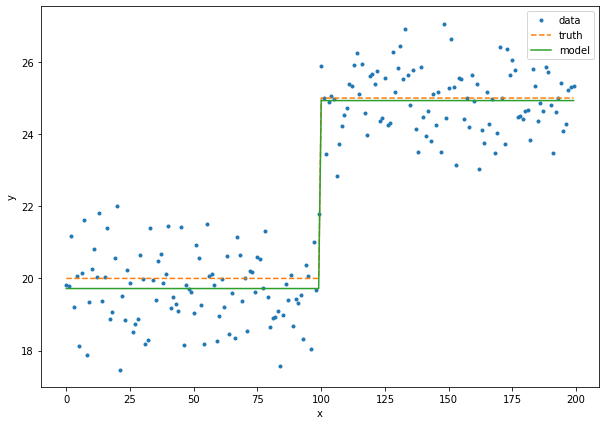

In [ ]:
poc, before, after = maxdiff(ym)   
fig = pl.figure(figsize=(10,7))
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Fig 2:** Point of change (POC) prediction obtained by maximizing the difference between means. The obtained POC is 100, which is in agreement with the way the data was created. The resulting means are between one standard deviation from the original ones.

#<font color='red'> FBB what did you mean here? "resulting means are between one standard deviation from the original ones." You did not calculate the standard deviation of the mean, as far as I can tell. I think whast you meant is that the calculated mean is within the std deviaion of the true mean but that is not quite what you wrote. Be specific</font>

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa22_6#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [ ]:
def poc_mse(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
     We choose the initial value of diff as the variance, since we're trying to find the minimum value of this quantity
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, np.std(y)**2*N, np.nan, np.nan

    for i in range(1, N):
        diff_here = np.sum((y[i:] - f(y[i:]))**2) +  np.sum((y[:i] - f(y[:i]))**2)
        if diff_here < diff:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))

poc: 100.00, mean before: 19.72, mean after: 24.93


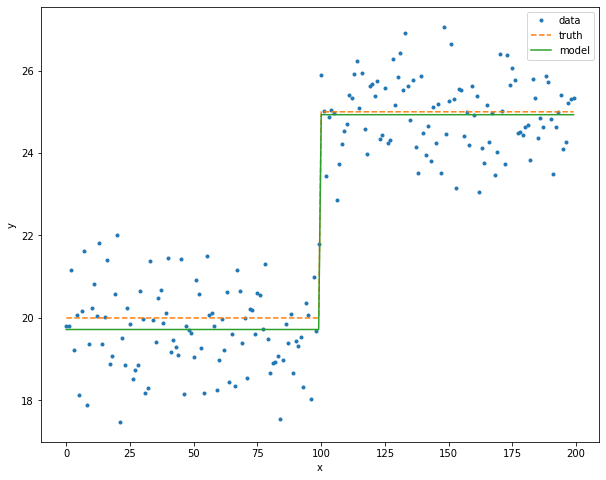

In [ ]:
poc, before, after = poc_mse(ym)   
fig = pl.figure(figsize=(10,8))
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Fig 3.** Prediction for a single point of change (S-POC) in our synthetic dataset, found by maximizing the difference between the mean squared error. The means before and after are within one standard deviation of the real mean.

The results are the same as with the previous method, maximizing the mean difference before and after the POC. 

#<font color='red'> FBB this caption is good</font>

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [ ]:
# Generate random points with standard deviations 1 and 4 and means 20 and 25 respectively
mu1, mu2 = 20, 25
s2 = 4
ys = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) * s2 + mu1])

In [ ]:
def maxdiff_sigma(y, sigma=False):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
     When sigma = True the difference in standard deviation is used instead of the mean
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan

    if sigma:
      #diff = np.std(y)**2*N
      for i in range(1, N):
        #diff_here = np.sum((y[i:] - f(y[i:]))**2)/(N-i) +  np.sum((y[:i] - f(y[:i]))**2)/(i-1)
        diff_here = np.abs(np.std(y[i:]) - np.std(y[:i]))
        if diff_here > diff:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])  
    else:
      for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    
    print(before, after)
    return(poc, before, after)

In [ ]:
print("poc: {:.2f}, standard deviation before: {:.2f}, mean after: {:.2f}".format(*maxdiff_sigma(ym, sigma=True)));

19.806895578716418 22.3374686689719
poc: 1.00, standard deviation before: 19.81, mean after: 22.34


#<font color='red'> FBB control the number of decimal digits in your print statements - it wil look a lot more professional</font>

In [ ]:
print("poc: {:.2f}, standard deviation before: {:.2f}, mean after: {:.2f}".format(*maxdiff_sigma(ys, sigma=True)));

20.132746487609452 19.69323570071284
poc: 100.00, standard deviation before: 20.13, mean after: 19.69


20.132746487609452 19.69323570071284


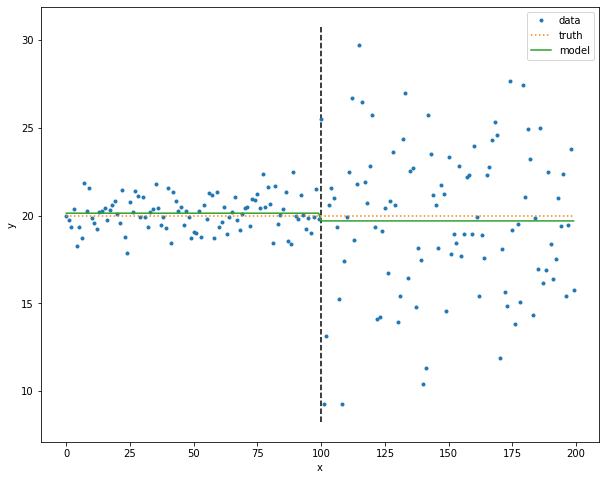

In [ ]:
poc, before, after = maxdiff_sigma(ys, sigma=True)
fig = pl.figure(figsize=(10,8))
ax = pl.gca()
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [mu1] * 200 , ':', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ys) - poc), label="model")
pl.xlabel('x')

pl.vlines(100, *ax.get_ylim(), linestyles='dashed')
pl.ylabel('y');
pl.legend();

**Fig 4.** POC prediction for our new dataset. The POC obtained was 199, through a maximization of the difference between standard deviation (STD) before and after the POC. The result is not the one expected, it is due to the size of the window we are considering. When choosing only the endpoints it is likely that the STD difference will be greater than at the point of change. This problem could be solved by using a rolling window method with an appropiate lengt in the future and in the past. It can also be more suitable to identify one or more POC.

#<font color='red'> FBB you did something wrong when you ran the notebook or you changed something **after** you ran it. I ran your notebook and correctly identified the POC at 100</font>

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

The Pelt algorithm is used to find the POC when we do not have information about how many points there are in the timeseries. There are two important parameters, the cost function used and the penalty. When I tried to use the l2 cost function the penalty needs to be significantly greater that one, otherwise it will find more than one point of change. I found more advantageous to use the rbf cost function since it required a lower value of penalty.

I still need to explore how to select a proper penalty value, so far I have only found an elbow plot, similar to the one for k means, as one apporach to determine the optimal penalty value.

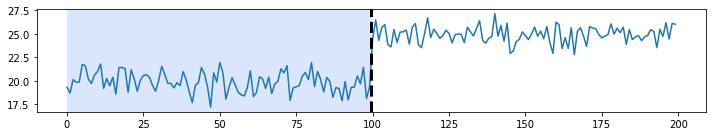

In [ ]:
algo = rpt.Pelt(model = 'rbf').fit(ym)
result = algo.predict(pen = 1.1)
rpt.display(ym, [100], result)
pl.show()

**Fig 5.** POC prediction using the rupture package and the PELT algorithm for the first synthetic set. The predicted POC was in agreement with the true value.

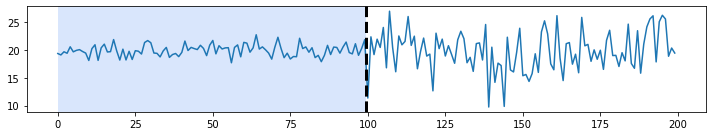

In [ ]:
# detection
algo = rpt.Pelt(model = 'rbf').fit(ys)
result = algo.predict(pen = 3)

# display
rpt.display(ys, [100], result)
pl.show()

**Fig 6.** POC prediction using the rupture package and the PELT algorithm for the second synthetic set. The predicted POC was in agreement with the true value. However, the penalty value for this dataset had to be increased with respect to Fig 5.

#<font color='red'> FBB good</font>

# read in the data from LANL earthquake prediction 
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [ ]:
eq1 = pd.read_csv('http://fbb.space/mltsa/LALNeq.csv')
eq1.describe()

,Unnamed: 0,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06,4.500000e+06
mean,2.250000e+06,4.616407e+00,8.852012e-01
std,1.299038e+06,2.614006e+01,3.374432e-01
min,0.000000e+00,-4.621000e+03,3.008971e-01
25%,1.125000e+06,2.000000e+00,5.934956e-01
50%,2.250000e+06,5.000000e+00,8.849986e-01
75%,3.374999e+06,7.000000e+00,1.177597e+00
max,4.499999e+06,3.252000e+03,1.469100e+00


In [ ]:
eq1.head()

,Unnamed: 0,acoustic_data,time_to_failure
0,0,12,1.4691
1,1,6,1.4691
2,2,8,1.4691
3,3,5,1.4691
4,4,8,1.4691


# using rupture

Go through the documentation of rupture. 

Look at the "cost functions" and "search methos" tab here - https://centre-borelli.github.io/ruptures-docs/user-guide/ and the paper https://arxiv.org/pdf/1801.00718.pdf to find the computational cost associate to each method (Section 5).

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




Look at the "cost functions" and "search methos" tab here - https://centre-borelli.github.io/ruptures-docs/user-guide/ and the paper https://arxiv.org/pdf/1801.00718.pdf to find the computational cost associate to each method.





Let's plot the first 1000, 5000, and 10000 points in the timeseries

In [ ]:
eq1.shape

(4500000, 3)

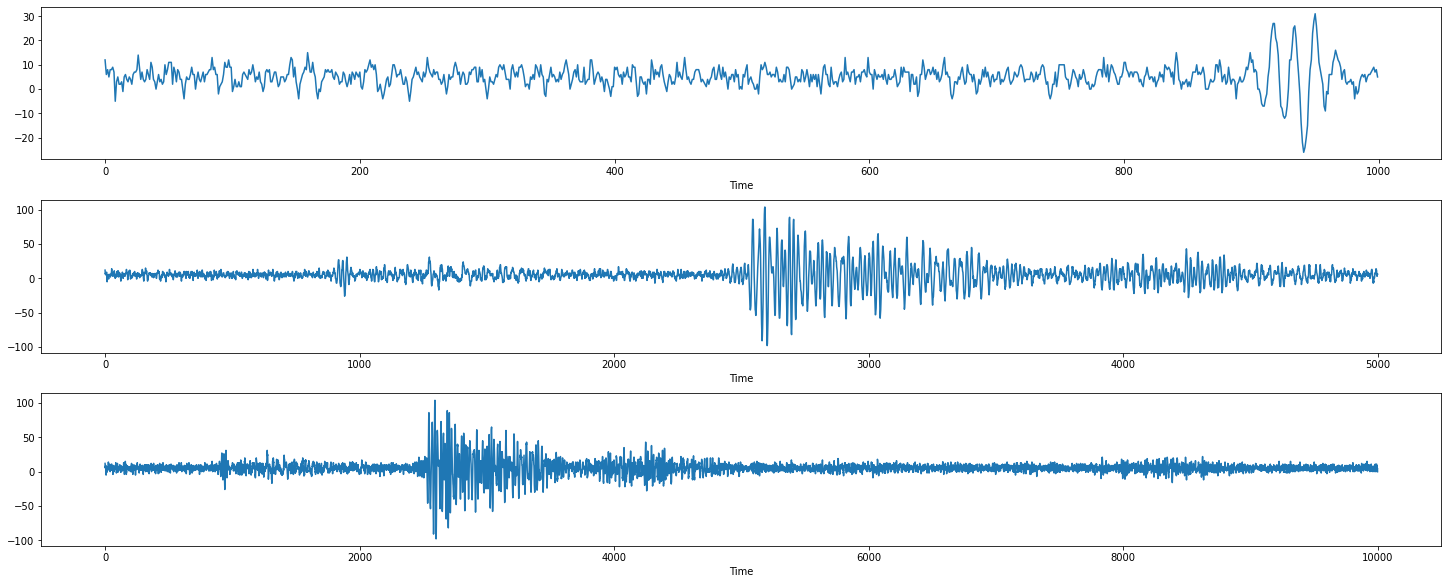

In [ ]:
points = [1000, 5000, 10000]
fig , ax = pl.subplots(nrows = 3, ncols = 1, figsize=(20,8), constrained_layout = True )
for i in range(3):
  ax[i].plot(eq1.acoustic_data[:points[i]])
  ax[i].set_xlabel('Time')

**Fig 7.** Eartquakes time series plots. Top plot shows the first 1000 points. Here, there is a clear change in the variance of the time series for almost a hundred points between steps 800 and 1000. Therefore, we expect that there will be around two POC. The middle plot shows the first 5000 points. Besides the behavior from the first thousand ones, there are at least two more regions where the variance in the time series is significantly different. In this sense, we would expect to find nearly 6 POC. The bottom plot shows the first 10000 points. In addition to the previous behaviour, there is an additional change in variance between the 8000-9000 steps.

#<font color='red'> FBB good!</font>

We chose Dynamic Programing, it has complexity of order 𝒪\(kN^2\)

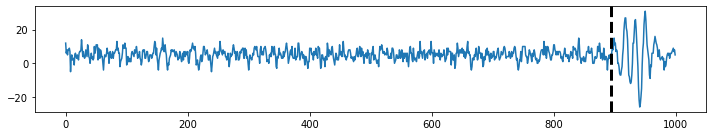

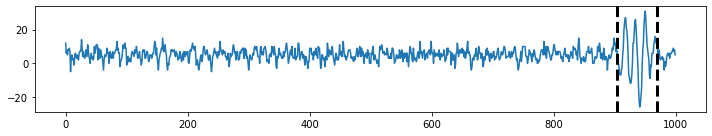

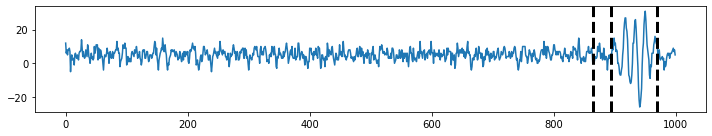

In [ ]:
n_sample = 1000
algo1 = rpt.Dynp(model = 'rbf', min_size = 30).fit(eq1.acoustic_data.values[:n_sample])
for i in range(1, 4):
  result = algo1.predict(n_bkps = i)
  rpt.display(eq1.acoustic_data.values[:n_sample], [], result)

**Fig 8** Dynamic Programming algorithm on the first thousand points of the dataset for 1, 2 and 3 POC. By inspection the set appears to have two well definite POC, however we did not run any algorithm or test to confirm this value. The min_sample size was set to 30, otherwise it will predict POC in spaces where there was clearly none. Considering that the most noticeable change in the variance spans a range of nearly a hundred points, this choice of min_sample is appropiate.
As expected, for k = 1 an d k = 2, the POC coincides with the initial visual diagnose. For k = 3 appears another POC around 840, where at first glance there is no change in the time series behaviour, this might indicate that we are overfitting.

#<font color='red'> FBB ok</font>

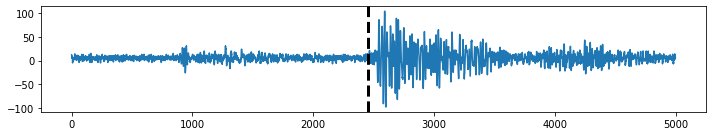

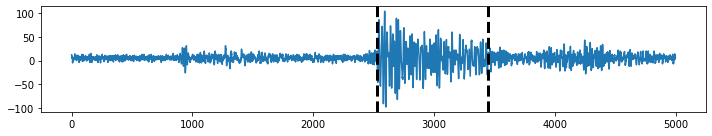

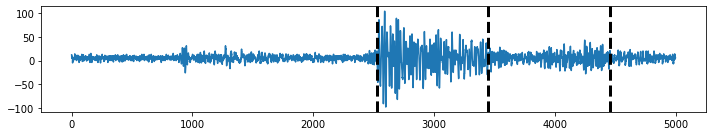

In [ ]:
n_sample = 5000
algo1 = rpt.Dynp(model = 'rbf', min_size = 30).fit(eq1.acoustic_data.values[:n_sample])
for i in range(1, 4):
  result = algo1.predict(n_bkps = i)
  rpt.display(eq1.acoustic_data.values[:n_sample], [], result)

**Fig 9.**  Dynamic Programming algorithm on the first five thousand points of the dataset for 1, 2 and 3 POC. Even though we would have expected to find more than 3 POC, the predictions for k = 1,2,3, all land on a point where appears to be a change in the time series variance. We used the same parameters as in Fig 8.
This plot took significantly longer than the previous one, nearly 8 hours to be made. This evidence the squared dependecy on the number of datapoints to be considered.

#<font color='red'> FBB ok</font>

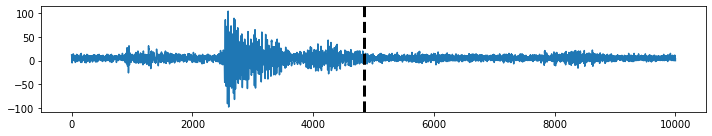

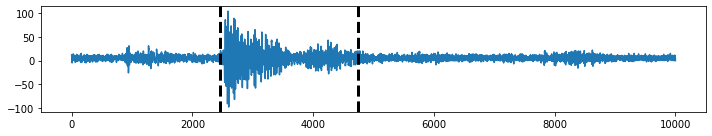

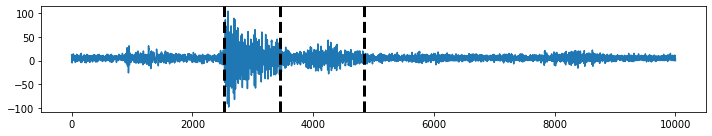

In [ ]:
n_sample = 10000
algo1 = rpt.Dynp(model = 'rbf', min_size = 30).fit(eq1.acoustic_data.values[:n_sample])
for i in range(1, 4):
  result = algo1.predict(n_bkps = i)
  rpt.display(eq1.acoustic_data.values[:n_sample], [], result)

**Fig 9.**  Dynamic Programming algorithm on the first ten thousand points of the dataset for 1, 2 and 3 POC. The POC predicte in each of the three cases are located in the regions where the variance changed the most, between steps 2000 and 5000. For k = 3 the results are very similar to Fig 8.
As in Fig 8, this plot took much longer than all the previous ones, nearly 12h to complete.

#<font color='red'> FBB I think what is significant is that the result for k=1 does not seem to be well justified - i _think_ it has to do with a bias to put the POC in the middle of the time series</font> 

Find a method that has computational complexity O(Nlog(N))

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

In [ ]:
algo4 = rpt.BottomUp(model = 'rbf').fit(eq1.acoustic_data.values[:10000])

In [ ]:
result4 = algo4.predict(n_bkps=2)

(<Figure size 720x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fc28e1f7f10>])

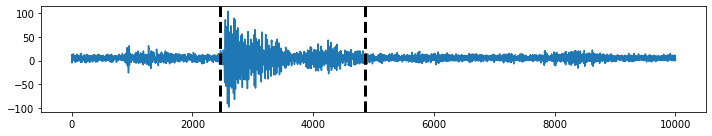

In [ ]:
rpt.display(eq1.acoustic_data.values[:10000], [], result4)

**Fig 10** POC detection using the Bottom Up Segmentation algorithm. As before we choose the rbf cost function and k = 2 to isolate 3 chunks of the time series. This algorithm was faster than Dynamic Programming and produced the same results as the middle panel in Fig 9.

#<font color='red'> FBB ok</font>

